## About this notebook

This notebook is based on [CQT G2Net EfficientNetB1[TPU Training]](https://www.kaggle.com/miklgr500/cqt-g2net-efficientnetb7-tpu-training-w-b) by [Welf Crozzo](https://www.kaggle.com/miklgr500) and [nnAudio Constant Q-transform Demonstration](https://www.kaggle.com/atamazian/nnaudio-constant-q-transform-demonstration) by [Araik Tamazian](https://www.kaggle.com/atamazian).

This notebook use Constant Q-Transform for feature extraction and EfficientNetB0 for classification. The whole pipeline is implemented with Tensorflow, and the training process runs on TPU.

The main difference between this notebook and Welf's notebook is the use of on-the-fly CQT computation implemented with Tensorflow, which is similar to the idea of [nnAudio](https://github.com/KinWaiCheuk/nnAudio)'s [CQT1992v2](https://kinwaicheuk.github.io/nnAudio/_autosummary/nnAudio.Spectrogram.CQT1992v2.html?highlight=cqt1992v2#nnAudio.Spectrogram.CQT1992v2) layer.

* [Inference Notebook](https://www.kaggle.com/hidehisaarai1213/g2net-tf-on-the-fly-cqt-tpu-inference)

## Install Dependencies

In [1]:
!pip install efficientnet tensorflow_addons > /dev/null

In [2]:
import os
import math
import random
import re
import warnings
from pathlib import Path
from typing import Optional, Tuple

import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets
from scipy.signal import get_window
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [3]:
tf.__version__

'2.4.1'

## Config

In [4]:
NUM_FOLDS = 4
IMAGE_SIZE = 256
BATCH_SIZE = 32
EFFICIENTNET_SIZE = 2
WEIGHTS = "imagenet"

MIXUP_PROB = 0.0
EPOCHS = 20
R_ANGLE = 0 / 180 * np.pi
S_SHIFT = 0.0
T_SHIFT = 0.0
LABEL_POSITIVE_SHIFT = 0.99

In [5]:
SAVEDIR = Path("models")
SAVEDIR.mkdir(exist_ok=True)

OOFDIR = Path("oof")
OOFDIR.mkdir(exist_ok=True)

## Utilities

In [6]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


set_seed(1213)

In [7]:
def auto_select_accelerator():
    TPU_DETECTED = False
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
        TPU_DETECTED = True
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy, TPU_DETECTED

In [8]:
strategy, tpu_detected = auto_select_accelerator()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


## Data Loading

In [9]:
gcs_paths = []
for i, j in [(0, 4), (5, 9), (10, 14), (15, 19)]:
    GCS_path = KaggleDatasets().get_gcs_path(f"g2net-waveform-tfrecords-train-{i}-{j}")
    gcs_paths.append(GCS_path)
    print(GCS_path)

gs://kds-b7801dbcf28ff97eb73ae6b53cab9392ab6f09f990a3de5ed4fef5c5
gs://kds-a47f829c8595536270b31ecf2940d9ec096f306b5da14b86c6f852c9
gs://kds-4bd8994b094df132d1803492e83675e01a51d9c1cbcf3e3da3de1d00
gs://kds-2ab0253546b07dfc3d38f3d9ea5c014db21d8f8cbd872b879c75beed


In [10]:
all_files = []
for path in gcs_paths:
    all_files.extend(np.sort(np.array(tf.io.gfile.glob(path + "/train*.tfrecords"))))

print("train_files: ", len(all_files))

train_files:  20


## Dataset Preparation

Here's the main contribution of this notebook - Tensorflow version of on-the-fly CQT computation. Note that some of the operations used in CQT computation are not supported by TPU, therefore the implementation is not a TF layer but a function that runs on CPU.

In [11]:
def create_cqt_kernels(
    q: float,
    fs: float,
    fmin: float,
    n_bins: int = 84,
    bins_per_octave: int = 12,
    norm: float = 1,
    window: str = "hann",
    fmax: Optional[float] = None,
    topbin_check: bool = True
) -> Tuple[np.ndarray, int, np.ndarray, float]:
    fft_len = 2 ** _nextpow2(np.ceil(q * fs / fmin))
    
    if (fmax is not None) and (n_bins is None):
        n_bins = np.ceil(bins_per_octave * np.log2(fmax / fmin))
        freqs = fmin * 2.0 ** (np.r_[0:n_bins] / np.float(bins_per_octave))
    elif (fmax is None) and (n_bins is not None):
        freqs = fmin * 2.0 ** (np.r_[0:n_bins] / np.float(bins_per_octave))
    else:
        warnings.warn("If nmax is given, n_bins will be ignored", SyntaxWarning)
        n_bins = np.ceil(bins_per_octave * np.log2(fmax / fmin))
        freqs = fmin * 2.0 ** (np.r_[0:n_bins] / np.float(bins_per_octave))
        
    if np.max(freqs) > fs / 2 and topbin_check:
        raise ValueError(f"The top bin {np.max(freqs)} Hz has exceeded the Nyquist frequency, \
                           please reduce the `n_bins`")
    
    kernel = np.zeros((int(n_bins), int(fft_len)), dtype=np.complex64)
    
    length = np.ceil(q * fs / freqs)
    for k in range(0, int(n_bins)):
        freq = freqs[k]
        l = np.ceil(q * fs / freq)
        
        if l % 2 == 1:
            start = int(np.ceil(fft_len / 2.0 - l / 2.0)) - 1
        else:
            start = int(np.ceil(fft_len / 2.0 - l / 2.0))

        sig = get_window(window, int(l), fftbins=True) * np.exp(
            np.r_[-l // 2:l // 2] * 1j * 2 * np.pi * freq / fs) / l
        
        if norm:
            kernel[k, start:start + int(l)] = sig / np.linalg.norm(sig, norm)
        else:
            kernel[k, start:start + int(l)] = sig
    return kernel, fft_len, length, freqs


def _nextpow2(a: float) -> int:
    return int(np.ceil(np.log2(a)))


def prepare_cqt_kernel(
    sr=22050,
    hop_length=512,
    fmin=32.70,
    fmax=None,
    n_bins=84,
    bins_per_octave=12,
    norm=1,
    filter_scale=1,
    window="hann"
):
    q = float(filter_scale) / (2 ** (1 / bins_per_octave) - 1)
    print(q)
    return create_cqt_kernels(q, sr, fmin, n_bins, bins_per_octave, norm, window, fmax)

In [12]:
HOP_LENGTH = 16
cqt_kernels, KERNEL_WIDTH, lengths, _ = prepare_cqt_kernel(
    sr=2048,
    hop_length=HOP_LENGTH,
    fmin=20,
    fmax=1024,
    bins_per_octave=24)
LENGTHS = tf.constant(lengths, dtype=tf.float32)
CQT_KERNELS_REAL = tf.constant(np.swapaxes(cqt_kernels.real[:, np.newaxis, :], 0, 2))
CQT_KERNELS_IMAG = tf.constant(np.swapaxes(cqt_kernels.imag[:, np.newaxis, :], 0, 2))
PADDING = tf.constant([[0, 0],
                        [KERNEL_WIDTH // 2, KERNEL_WIDTH // 2],
                        [0, 0]])

34.12708770892056


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SyntaxWarning: If nmax is given, n_bins will be ignored


In [13]:
def create_cqt_image(wave, hop_length=16):
    CQTs = []
    for i in range(3):
        x = wave[i]
        x = tf.expand_dims(tf.expand_dims(x, 0), 2)
        x = tf.pad(x, PADDING, "REFLECT")

        CQT_real = tf.nn.conv1d(x, CQT_KERNELS_REAL, stride=hop_length, padding="VALID")
        CQT_imag = -tf.nn.conv1d(x, CQT_KERNELS_IMAG, stride=hop_length, padding="VALID")
        CQT_real *= tf.math.sqrt(LENGTHS)
        CQT_imag *= tf.math.sqrt(LENGTHS)

        CQT = tf.math.sqrt(tf.pow(CQT_real, 2) + tf.pow(CQT_imag, 2))
        CQTs.append(CQT[0])
    return tf.stack(CQTs, axis=2)

In [14]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        "wave": tf.io.FixedLenFeature([], tf.string),
        "wave_id": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return prepare_image(example["wave"], IMAGE_SIZE), tf.reshape(tf.cast(example["target"], tf.float32), [1])


def read_unlabeled_tfrecord(example, return_image_id):
    tfrec_format = {
        "wave": tf.io.FixedLenFeature([], tf.string),
        "wave_id": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return prepare_image(example["wave"], IMAGE_SIZE), example["wave_id"] if return_image_id else 0


def count_data_items(fileids):
    return len(fileids) * 28000


def count_data_items_test(fileids):
    return len(fileids) * 22600


def mixup(image, label, probability=0.5, aug_batch=64 * 8):
    imgs = []
    labs = []
    for j in range(aug_batch):
        p = tf.cast(tf.random.uniform([], 0, 1) <= probability, tf.float32)
        k = tf.cast(tf.random.uniform([], 0, aug_batch), tf.int32)
        a = tf.random.uniform([], 0, 1) * p

        img1 = image[j]
        img2 = image[k]
        imgs.append((1 - a) * img1 + a * img2)
        lab1 = label[j]
        lab2 = label[k]
        labs.append((1 - a) * lab1 + a * lab2)
    image2 = tf.reshape(tf.stack(imgs), (aug_batch, IMAGE_SIZE, IMAGE_SIZE, 3))
    label2 = tf.reshape(tf.stack(labs), (aug_batch,))
    return image2, label2


def time_shift(img, shift=T_SHIFT):
    if shift > 0:
        T = IMAGE_SIZE
        P = tf.random.uniform([],0,1)
        SHIFT = tf.cast(T * P, tf.int32)
        return tf.concat([img[-SHIFT:], img[:-SHIFT]], axis=0)
    return img


def rotate(img, angle=R_ANGLE):
    if angle > 0:
        P = tf.random.uniform([],0,1)
        A = tf.cast(angle * P, tf.float32)
        return tfa.image.rotate(img, A)
    return img


def spector_shift(img, shift=S_SHIFT):
    if shift > 0:
        T = IMAGE_SIZE
        P = tf.random.uniform([],0,1)
        SHIFT = tf.cast(T * P, tf.int32)
        return tf.concat([img[:, -SHIFT:], img[:, :-SHIFT]], axis=1)
    return img

def img_aug_f(img):
    img = time_shift(img)
    img = spector_shift(img)
    # img = rotate(img)
    return img


def imgs_aug_f(imgs, batch_size):
    _imgs = []
    DIM = IMAGE_SIZE
    for j in range(batch_size):
        _imgs.append(img_aug_f(imgs[j]))
    return tf.reshape(tf.stack(_imgs),(batch_size,DIM,DIM,3))


def label_positive_shift(labels):
    return labels * LABEL_POSITIVE_SHIFT


def aug_f(imgs, labels, batch_size):
    imgs, label = mixup(imgs, labels, MIXUP_PROB, batch_size)
    imgs = imgs_aug_f(imgs, batch_size)
    return imgs, label_positive_shift(label)


def prepare_image(wave, dim=256):
    wave = tf.reshape(tf.io.decode_raw(wave, tf.float64), (3, 4096))
    normalized_waves = []
    for i in range(3):
        normalized_wave = wave[i] / tf.math.reduce_max(wave[i])
        normalized_waves.append(normalized_wave)
    wave = tf.stack(normalized_waves)
    wave = tf.cast(wave, tf.float32)
    image = create_cqt_image(wave, HOP_LENGTH)
    image = tf.image.resize(image, size=(dim, dim))
    return tf.reshape(image, (dim, dim, 3))


def get_dataset(files, batch_size=16, repeat=False, shuffle=False, aug=True, labeled=True, return_image_ids=True):
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO, compression_type="GZIP")
    ds = ds.cache()

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(1024 * 2)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    if labeled:
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_ids), num_parallel_calls=AUTO)

    ds = ds.batch(batch_size * REPLICAS)
    if aug:
        ds = ds.map(lambda x, y: aug_f(x, y, batch_size * REPLICAS), num_parallel_calls=AUTO)
    ds = ds.prefetch(AUTO)
    return ds

## Model

In [15]:
def build_model(size=256, efficientnet_size=0, weights="imagenet", count=0):
    inputs = tf.keras.layers.Input(shape=(size, size, 3))
    
    efn_string= f"EfficientNetB{efficientnet_size}"
    efn_layer = getattr(efn, efn_string)(input_shape=(size, size, 3), weights=weights, include_top=False)

    x = efn_layer(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)

    lr_decayed_fn = tf.keras.experimental.CosineDecay(1e-3, count)
    opt = tfa.optimizers.AdamW(lr_decayed_fn, learning_rate=1e-4)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=opt, loss=loss, metrics=["AUC"])
    return model

In [16]:
def get_lr_callback(batch_size=8, replicas=8):
    lr_start   = 1e-4
    lr_max     = 0.000015 * replicas * batch_size
    lr_min     = 1e-7
    lr_ramp_ep = 3
    lr_sus_ep  = 0
    lr_decay   = 0.7
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
    return lr_callback

## Training

In [17]:
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=1213)
oof_pred = []
oof_target = []

files_train_all = np.array(all_files)

Fold 0
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
31940608/31936256 [==============================] - 1s 0us/step
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
410/410 [==============================] - 270s 415ms/step - loss: 0.6065 - auc: 0.6979 - val_loss: 0.6867 - val_auc: 0.5899

Epoch 00001: val_auc improved from -inf to 0.58990, saving model to models/fold0.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0013466666666666668.
410/410 [==============================] - 137s 335ms/step - loss: 0.5084 - auc: 0.8117 - val_loss: 0.4958 - val_auc: 0.8442

Epoch 00002: val_auc improved from 0.58990 to 0.84423, saving model to models/fold0.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0025933333333333333.
410/410 [==============================] - 140s 342ms/step - loss: 0.4793 - auc: 0.8335 - val_loss: 0.5005 - val_auc: 0.8475

Epoch 00003: val_auc improved from 0.84423 to 0

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


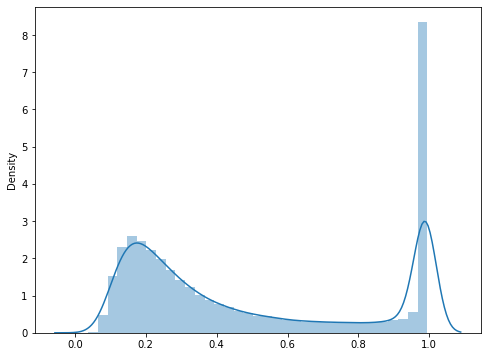

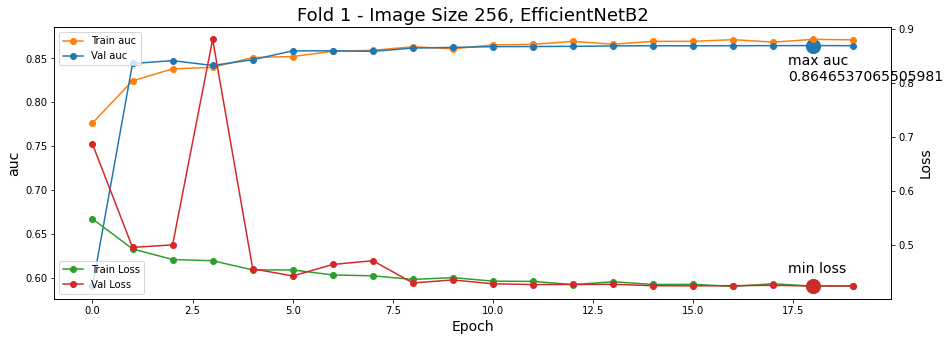

Fold 1
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
410/410 [==============================] - 250s 353ms/step - loss: 0.6028 - auc: 0.7020 - val_loss: 0.7205 - val_auc: 0.5529

Epoch 00001: val_auc improved from -inf to 0.55288, saving model to models/fold1.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0013466666666666668.
410/410 [==============================] - 134s 327ms/step - loss: 0.5052 - auc: 0.8133 - val_loss: 0.4671 - val_auc: 0.8450

Epoch 00002: val_auc improved from 0.55288 to 0.84500, saving model to models/fold1.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0025933333333333333.
410/410 [==============================] - 134s 327ms/step - loss: 0.4806 - auc: 0.8340 - val_loss: 0.8780 - val_auc: 0.8059

Epoch 00003: val_auc did not improve from 0.84500
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learni

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


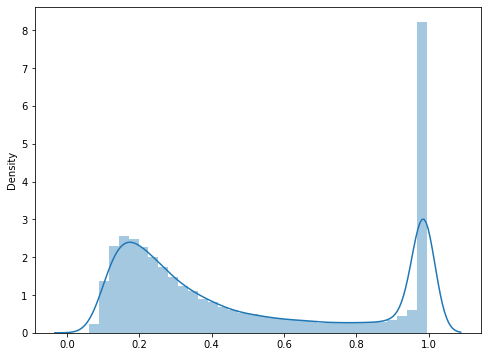

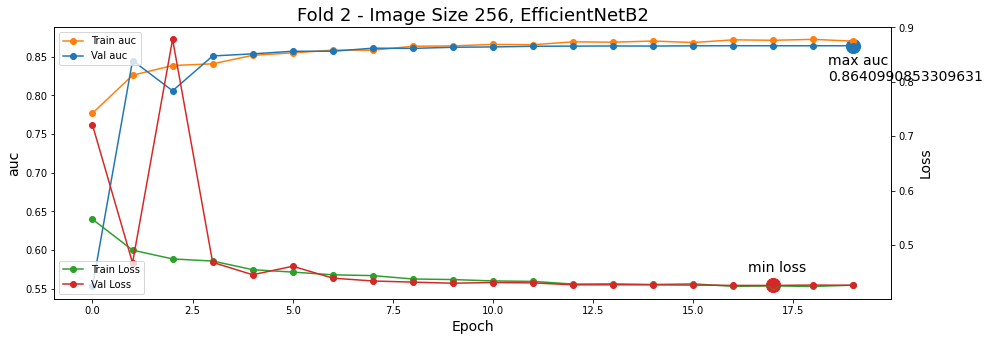

Fold 2
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
410/410 [==============================] - 248s 354ms/step - loss: 0.6074 - auc: 0.6952 - val_loss: 0.6893 - val_auc: 0.5513

Epoch 00001: val_auc improved from -inf to 0.55129, saving model to models/fold2.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0013466666666666668.
410/410 [==============================] - 135s 329ms/step - loss: 0.5061 - auc: 0.8136 - val_loss: 0.4649 - val_auc: 0.8379

Epoch 00002: val_auc improved from 0.55129 to 0.83788, saving model to models/fold2.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0025933333333333333.
410/410 [==============================] - 135s 330ms/step - loss: 0.4790 - auc: 0.8339 - val_loss: 0.4524 - val_auc: 0.8475

Epoch 00003: val_auc improved from 0.83788 to 0.84753, saving model to models/fold2.h5
Epoch 4/20

Epoch 00004: 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


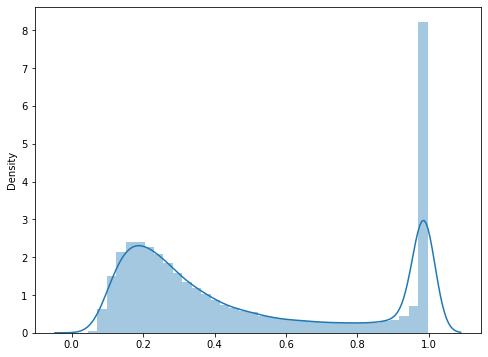

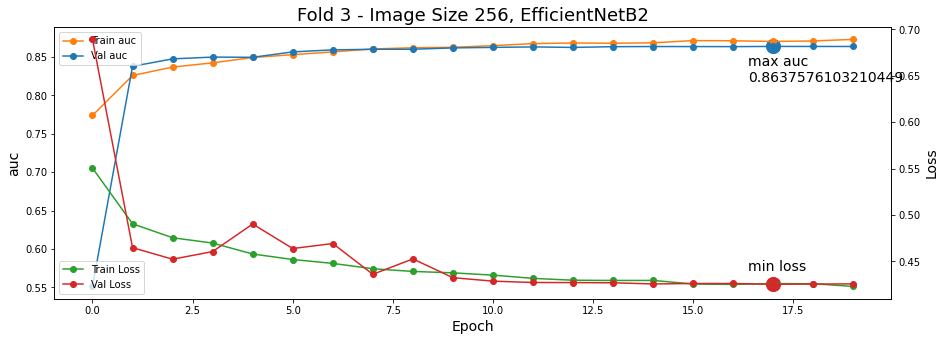

Fold 3
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
410/410 [==============================] - 255s 355ms/step - loss: 0.6034 - auc: 0.7024 - val_loss: 0.6988 - val_auc: 0.5619

Epoch 00001: val_auc improved from -inf to 0.56185, saving model to models/fold3.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0013466666666666668.
410/410 [==============================] - 134s 327ms/step - loss: 0.5063 - auc: 0.8120 - val_loss: 0.4578 - val_auc: 0.8464

Epoch 00002: val_auc improved from 0.56185 to 0.84644, saving model to models/fold3.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0025933333333333333.
410/410 [==============================] - 135s 329ms/step - loss: 0.4793 - auc: 0.8336 - val_loss: 0.4692 - val_auc: 0.8509

Epoch 00003: val_auc improved from 0.84644 to 0.85087, saving model to models/fold3.h5
Epoch 4/20

Epoch 00004: 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


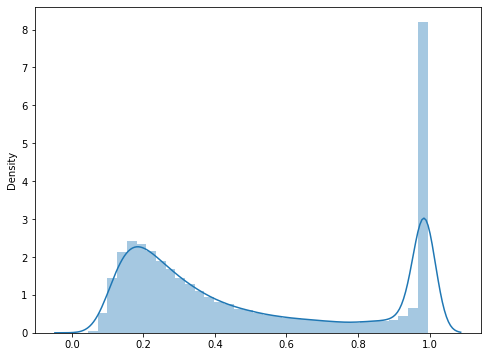

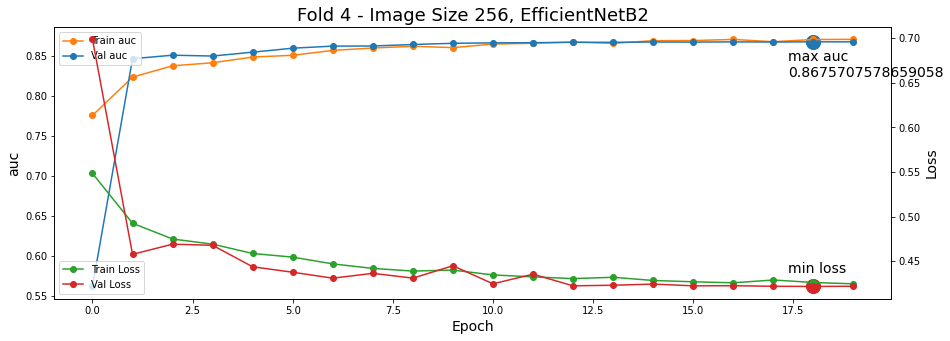

In [18]:
for fold, (trn_idx, val_idx) in enumerate(kf.split(files_train_all)):
    files_train = files_train_all[trn_idx]
    files_valid = files_train_all[val_idx]

    print("=" * 120)
    print(f"Fold {fold}")
    print("=" * 120)

    train_image_count = count_data_items(files_train)
    valid_image_count = count_data_items(files_valid)

    tf.keras.backend.clear_session()
    strategy, tpu_detected = auto_select_accelerator()
    with strategy.scope():
        model = build_model(
            size=IMAGE_SIZE, 
            efficientnet_size=EFFICIENTNET_SIZE,
            weights=WEIGHTS, 
            count=train_image_count // BATCH_SIZE // REPLICAS // 4)
    
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        str(SAVEDIR / f"fold{fold}.h5"), monitor="val_auc", verbose=1, save_best_only=True,
        save_weights_only=True, mode="max", save_freq="epoch"
    )

    history = model.fit(
        get_dataset(files_train, batch_size=BATCH_SIZE, shuffle=True, repeat=True, aug=True),
        epochs=EPOCHS,
        callbacks=[model_ckpt, get_lr_callback(BATCH_SIZE, REPLICAS)],
        steps_per_epoch=train_image_count // BATCH_SIZE // REPLICAS // 4,
        validation_data=get_dataset(files_valid, batch_size=BATCH_SIZE * 4, repeat=False, shuffle=False, aug=False),
        verbose=1
    )

    print("Loading best model...")
    model.load_weights(str(SAVEDIR / f"fold{fold}.h5"))

    ds_valid = get_dataset(files_valid, labeled=False, return_image_ids=False, repeat=True, shuffle=False, batch_size=BATCH_SIZE * 2, aug=False)
    STEPS = valid_image_count / BATCH_SIZE / 2 / REPLICAS
    pred = model.predict(ds_valid, steps=STEPS, verbose=0)[:valid_image_count]
    oof_pred.append(np.mean(pred.reshape((valid_image_count, 1), order="F"), axis=1))

    ds_valid = get_dataset(files_valid, repeat=False, labeled=True, return_image_ids=True, aug=False)
    oof_target.append(np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]))

    plt.figure(figsize=(8, 6))
    sns.distplot(oof_pred[-1])
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(
        np.arange(len(history.history["auc"])),
        history.history["auc"],
        "-o",
        label="Train auc",
        color="#ff7f0e")
    plt.plot(
        np.arange(len(history.history["auc"])),
        history.history["val_auc"],
        "-o",
        label="Val auc",
        color="#1f77b4")
    
    x = np.argmax(history.history["val_auc"])
    y = np.max(history.history["val_auc"])

    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]

    plt.scatter(x, y, s=200, color="#1f77b4")
    plt.text(x - 0.03 * xdist, y - 0.13 * ydist, f"max auc\n{y}", size=14)

    plt.ylabel("auc", size=14)
    plt.xlabel("Epoch", size=14)
    plt.legend(loc=2)

    plt2 = plt.gca().twinx()
    plt2.plot(
        np.arange(len(history.history["auc"])),
        history.history["loss"],
        "-o",
        label="Train Loss",
        color="#2ca02c")
    plt2.plot(
        np.arange(len(history.history["auc"])),
        history.history["val_loss"],
        "-o",
        label="Val Loss",
        color="#d62728")
    
    x = np.argmin(history.history["val_loss"])
    y = np.min(history.history["val_loss"])
    
    ydist = plt.ylim()[1] - plt.ylim()[0]

    plt.scatter(x, y, s=200, color="#d62728")
    plt.text(x - 0.03 * xdist, y + 0.05 * ydist, "min loss", size=14)

    plt.ylabel("Loss", size=14)
    plt.title(f"Fold {fold + 1} - Image Size {IMAGE_SIZE}, EfficientNetB{EFFICIENTNET_SIZE}", size=18)

    plt.legend(loc=3)
    plt.savefig(OOFDIR / f"fig{fold}.png")
    plt.show()

## OOF

In [19]:
oof = np.concatenate(oof_pred)
true = np.concatenate(oof_target)
auc = roc_auc_score(y_true=true, y_score=oof)
print(f"AUC: {auc:.5f}")

AUC: 0.86493


In [20]:
df = pd.DataFrame({
    "y_true": true.reshape(-1),
    "y_pred": oof
})
df.head()

,y_true,y_pred
0,0.0,0.260248
1,1.0,0.233667
2,1.0,0.128415
3,1.0,0.399959
4,0.0,0.467967


In [21]:
df.to_csv(OOFDIR / f"oof.csv", index=False)